In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

DATA_PATH = "./basic"

In [2]:
# Load images function
def load_data(path_to_data, directory):
    # load text file with image labels as a dictionary
    labels = pd.read_csv(os.path.join(path_to_data, "EmoLabel/list_patition_label.txt"), sep=" ", header=None)
    labels = dict(zip(labels[0], labels[1]))
    
    # update path_to_data
    path_to_data = os.path.join(path_to_data, "Image", directory)

    train_img = []
    train_labels = []
    test_img = []
    test_labels = []
    
    for file in os.listdir(path_to_data):
        image_path = os.path.join(path_to_data, file)
        image = load_img(image_path)
        img_arr = img_to_array(image, dtype=int)
        if directory == "aligned":
            label = labels[file.replace("_aligned", "")]
        else:
            label = labels[file]
        if "train" in file:
            train_img.append(img_arr)
            train_labels.append(label)
        else:
            test_img.append(img_arr)
            test_labels.append(label)

    train_labels = np.array(train_labels, dtype=int)
    test_labels = np.array(test_labels, dtype=int)
    
    if directory == "aligned":
        train_img = np.array(train_img)
        test_img = np.array(test_img)

        # Apply random shufflying to training examples.
        np.random.seed(0)
        indices = np.arange(train_img.shape[0])
        shuffled_indices = np.random.permutation(indices)
        train_img = train_img[shuffled_indices]
        train_labels = train_labels[shuffled_indices]

    return train_img, train_labels, test_img, test_labels

In [3]:
# Load label names
label_names_dict = {1: 'surprise', 2: 'fear', 3: 'disgust', 4: 'happiness', 5: 'sadness', 6: 'anger', 7: 'neutral'}

# Images are loaded as ints from 0 to 255
# Load training images and labels (original)
# Note: Loads images as a regular list since images are all different sizes. Labels are numpy array. 
# If loading originals, they will require further processing and shuffling. 
#train_img_org, train_labels_org, test_img_org, test_labels_org = load_data(DATA_PATH, "original")

# Load training images and labels (aligned)
# Converts images to numpy array since images are 100x100 and shuffles them. Labels are numpy array. 
train_img_aligned, train_labels_aligned, test_img_aligned, test_labels_aligned = load_data(DATA_PATH, "aligned")


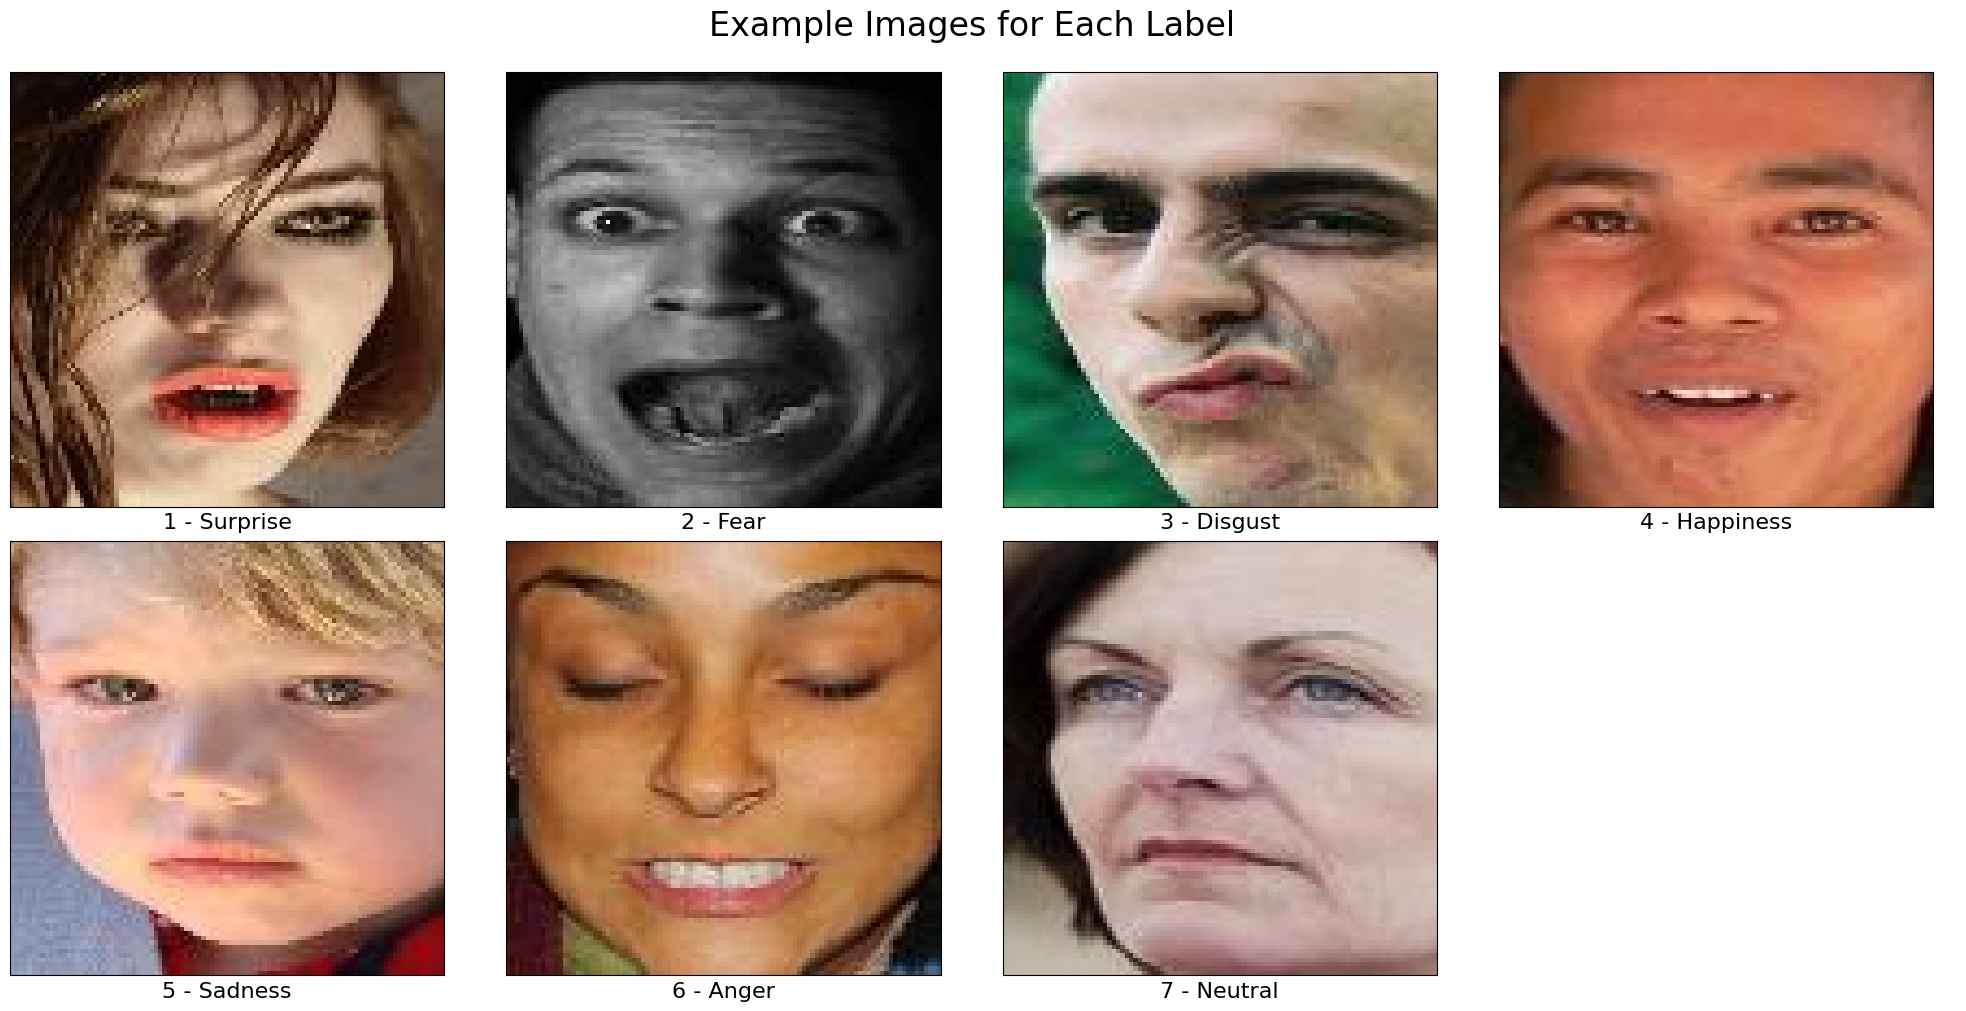

In [4]:
# Display images in 2 rows: 4 on top, 3 on bottom
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Example Images for Each Label', fontsize=24, y=1)

unique, indices = np.unique(train_labels_aligned, return_index=True)

pics = []
for idx, num in enumerate(indices):
    pics.append(train_img_aligned[num]) 

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Plot images
for i in range(8): 
    if i < 7:  
        axes_flat[i].imshow(pics[i])  
        axes_flat[i].tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            labelbottom=False,
            labelleft=False,
            grid_alpha=0)
        axes_flat[i].set_xlabel(str(unique[i]) + " - " + label_names_dict[unique[i]].title(), fontsize=16)
    else:  # Turn off the last unused spot
        axes_flat[i].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

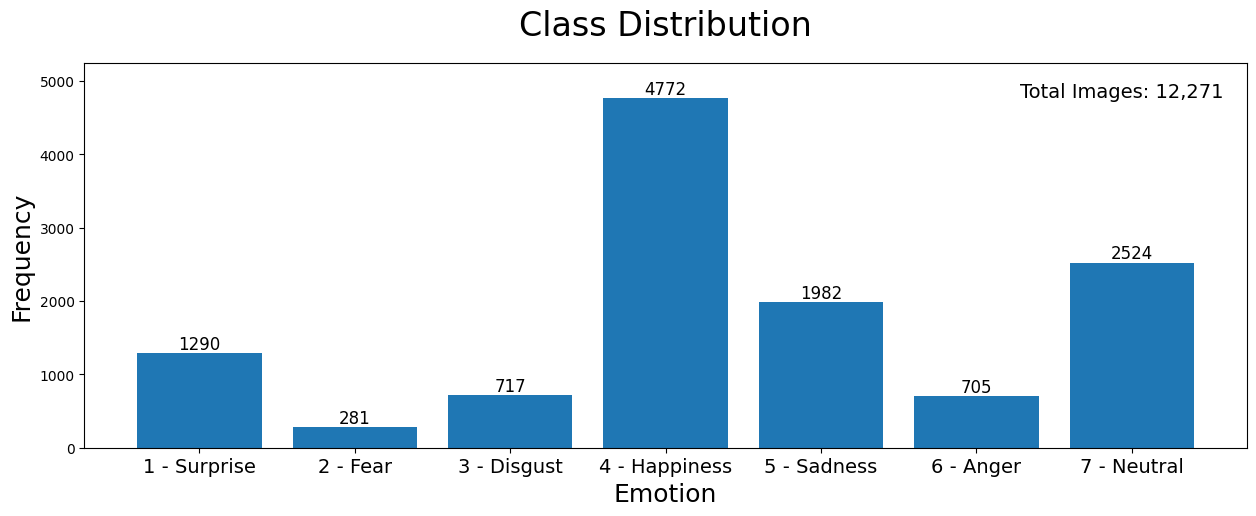

In [5]:
# Find unique value counts
unique, counts = np.unique(train_labels_aligned, return_counts=True)
classes = [str(num) + " - " + label_names_dict[num].title() for num in unique]
total_count = sum(counts)

# Create plot
plt.figure(figsize=(15, 5))
bars = plt.bar(range(len(counts)), counts)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Label/title plot
plt.title("Class Distribution", fontsize=24, y=1.05)
plt.xlabel("Emotion", fontsize=18)
plt.xticks(np.arange(len(counts)), classes, fontsize=14)
plt.ylabel("Frequency", fontsize=18)
plt.ylim(0, max(counts) * 1.1)
# Add total count as text annotation in upper right
plt.text(0.98, 0.95, f'Total Images: {total_count:,}', 
         transform=plt.gca().transAxes,
         ha='right', va='top',
         fontsize=14)

# Render plot
plt.show()

### Adding Canny Edges to the Images

Canny edges can be added as a channel into the images (shape will then become (H, W, 4) instead of (H, W, 3)) and added as an input into the model, or be used in a pipeline to identify contours of facial landmarks (such as eyes, mouth, nose, etc), or sillhouettes, which can be included as feature statistics into the model.

The below function adds the canny filters into the image as an extra channel and outputs the manipulated image into a designated output folder. we can adjust this to output each image individually or some other format for our pipeline, depending on how it fits with the other feature extraction steps. 

### Template Matching statistics as Selected Features
One way to use template matching for feature engineering would be to have templates for each facial expression (e.g. raised eyebrows and open mouth for suprise, smile and thinner eyes for happy, etc). The below function gathers similarity metrics between an image and a template and could be implemented into a pipeline for us to gather these summary statistics across all facial expression templates. E.g. min_val, max_val, avg_score, std_score will be gathered for each facial expression and included in our feature set. 



In [ ]:
import os
import cv2
import numpy as np


def process_images_with_canny(input_folder, output_folder, lower_threshold = 50, upper_threshold = 150): #suggested thresholds for detecting edges with canny
    """ Converts images to grayscale, enhances contrast, and applies Canny edge detection. """
    os.makedirs(output_folder, exist_ok=True)
       
    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # applying histogram equalization to enhance contrast
        img = cv2.equalizeHist(img)
        
        
        # apply canny edge detection
        edges = cv2.Canny(img, lower_threshold, upper_threshold)
        
        
        # Stack the original image with the Canny edge map
        img_combined = np.dstack([img, edges])  # Shape (H, W, 4) -> RGB + Canny

        
        #saving processed image
        output_path = os.path.join(output_folder, filename.split('.')[0] + '.npy')
        np.save(output_path, img_combined)
        
    
    print('Finished processsing images and saved to', output_path)

 
 
 
def template_matching_metrics(image_path, template_path):
     """ 
     This function takes in file path of an image and a facial template 
     and outputs three metrics corresponding to similarity to template: max_val, avg_score, std_score
     """

     # loading image and templates
     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
     template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)

     # applying Canny edge detection
     img_edges = cv2.Canny(img, 50, 150)
     template_edges = cv2.Canny(template, 50, 150)

     # using cv2.mathTemplate to see how well image matches template
     result = cv2.matchTemplate(img_edges, template_edges, cv2.TM_CCOEFF_NORMED)
     
     # getting the best match score
     min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result) 

     # computing output statistics
     avg_score = np.mean(result)  # Average match score
     std_score = np.std(result)   # Standard deviation of scores

     return min_val, max_val, avg_score, std_score
 
